# [프로젝트] 의도 분류 기반 RAG 수행하기 (Part 2)

![Image](https://github.com/user-attachments/assets/1a16653d-fdb9-4980-8ac3-ed8e20a2be45)

파트 1의 코드에서 LLM은 단일 검색을 통해 답변을 생성했기 때문에,    
여러 개의 DB를 연속적으로 활용하지 못했습니다.

이번에는 LLM이 결과를 점검하며, 추가 질의를 수행할 수 있는지 확인해 보겠습니다.

---

이번 프로젝트의 데이터 구성은 다음과 같습니다:   
rag.zip 파일을 업로드해 주세요.

<br><br>
rag/templates/*.md : 사내 문서 작성을 위한 양식 목록 (markdown)       
rag/company_policies.pdf : 사내 규정 파일 (PDF)    
rag/employee_data.csv : 사내 구성원 정보(CSV)   

**벡터 데이터베이스 실행을 위해, T4 GPU를 설정해 주세요!**

In [1]:
!pip install langchain==1.0.3
!pip install unstructured pymupdf langgraph langchain_google_genai langchain_community langchain-huggingface python-dotenv -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.3/469.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.79
    Uninstalling langchain-core-0.3.79:
      Successfully uninstalled langchain-core-0.3.79
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.27
    Uninstalling langchain-0.3.27:
      Successfully uninstalled langchain-0.3.27
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 40.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8

In [2]:
# RAG
!pip install langchain-chroma sentence_transformers kiwipiepy rank_bm25

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 36.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

**설치 후 런타임 --> 세션 다시 시작 해 주세요!**

이번 실습에서는 API 키를 입력하는 대신에,    
.env 파일에서 API 키를 불러옵니다.   
실제 API 키를 다음과 같이 넣어주세요!   

```
GOOGLE_API_KEY= 'AIzaSyAxxxxx'
LANGCHAIN_API_KEY='lsv2_pt_f3d94440f7d045c0a8dbe1f----'
```

**.env 파일은 숨김 파일이므로, 오른쪽 파일 탭의 눈(Eye) 표시를 클릭하시면 보입니다 :)**

업로드한 파일의 압축을 해제합니다.

In [3]:
import zipfile

with zipfile.ZipFile('rag.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

LLM과 임베딩 모델을 설정합니다.

In [4]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEmbeddings
from dotenv import load_dotenv

# .env 파일 로드
load_dotenv()

os.environ['LANGCHAIN_PROJECT'] = 'LangGraph_FastCampus'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_TRACING_V2']='true'

# 모델 설정
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.1
)

# 임베딩 모델 설정 (실제로 활용하실 때는 더 큰 임베딩 모델이 좋습니다!)
embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/multilingual-e5-small"
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [7]:
from typing import TypedDict, List, Dict, Any, Optional, Literal
from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END

from langchain_chroma import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import PyMuPDFLoader, CSVLoader, DirectoryLoader
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter

class IntentResult(BaseModel):
    explanation: str
    retrieval_needed: bool = Field(description='DB 검색이 필요한지의 여부 ')
    target_db: Literal["policy", "user", "form"] = Field(
        description="""사용자 질의를 해결하기 위해, 추가로 검색해야 하는 DB의 종류:
policy: 사내 규정집
user: 직원 정보
form: 문서 양식 모음""")
    query: str = Field(description='벡터 데이터베이스에 검색할 쿼리')

# State 정의
class State(TypedDict):
    question: str  # 사용자 질의
    target_db: str  # 검색하고자 하는 DB
    query: str # 검색어
    retrieval_needed: bool # 검색이 필요한지의 여부
    context: List[str]  # RAG 검색 결과
    draft: str# 중간 응답
    error: Optional[str]  # 에러 메시지
    retrieval_count: int

In [8]:
from kiwipiepy import Kiwi
# kiwi 형태소 분석기 설정
kiwi = Kiwi()
def kiwi_tokenize(text):
    return [token.form for token in kiwi.tokenize(text)]

In [10]:
import json
import os
from langchain_classic.retrievers import BM25Retriever, EnsembleRetriever
import uuid
from langchain_core.documents import Document

def load_data():
    # 3000/300 청킹: 데이터에 따라 조정
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=3000,
        chunk_overlap=300,
    )

    policy_file = './rag/company_policies.pdf'
    print(f"[{policy_file}] 문서 로드 중...")

    # 벡터스토어 업데이트
    policy_vectorstore =  Chroma(
    persist_directory="./chroma_db_policy_"+str(uuid.uuid4())[:5],
    embedding_function=embeddings,
    collection_name="policy_collection"
    )
    docs = PyMuPDFLoader(policy_file).load()
    split_docs = text_splitter.split_documents(docs)
    policy_vectorstore.add_documents(split_docs)
    print(f"[{policy_file}] 청킹 완료: {len(split_docs)}개의 청크로 분할됨")


    # 벡터 + BM25 리트리버 생성 (Top 5)
    policy_vector_retriever = policy_vectorstore.as_retriever(search_kwargs={"k": 5})
    policy_bm25_retriever = BM25Retriever.from_documents(split_docs,
                                                          preprocess_func=kiwi_tokenize)
    policy_bm25_retriever.k = 5

    # 하이브리드 리트리버 생성
    policy_retriever = EnsembleRetriever(
        retrievers=[policy_bm25_retriever, policy_vector_retriever],
        weights=[0.5, 0.5]
    )
    print(f"[{policy_file}] 하이브리드 검색 설정됨")


    ###############


    # 사용자 정보 처리
    user_file = './rag/employee_data.csv'
    print(f"[{user_file}] 문서 로드 중...")


    try:
        docs = CSVLoader(user_file).load()
    except:
        docs = CSVLoader(user_file, encoding='cp949').load()
    # CSV 파일의 경우, 하나의 document가 작으므로 결합하여 청킹
    hr_info = Document(page_content="사용자 정보:")
    for doc in docs:
        hr_info.page_content += f"\n{doc.page_content}+\n"


    # 짧은 맥락으로 이해 가능한 경우, 청크 크기 줄이기
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=2000,
        chunk_overlap=200,
    )

    split_docs = text_splitter.split_documents([hr_info])

    # 벡터 DB 생성
    user_vectorstore =  Chroma(
    persist_directory="./chroma_db_user_"+str(uuid.uuid4())[:5],
    embedding_function=embeddings,
    collection_name="user_collection"
    )

    print(f"[{user_file}] 청킹 완료: {len(split_docs)}개의 청크로 분할됨")

    # 벡터 + BM25 리트리버 생성 (Top 5)
    user_vector_retriever = user_vectorstore.as_retriever(search_kwargs={"k": 5})
    user_bm25_retriever = BM25Retriever.from_documents(split_docs, preprocess_func=kiwi_tokenize)
    user_bm25_retriever.k = 5

    # 하이브리드 리트리버 생성
    user_retriever = EnsembleRetriever(
        retrievers=[user_bm25_retriever, user_vector_retriever],
        weights=[0.7, 0.3]
        # 이름 등의 고유명사가 중요한 경우 BM25 가중치 높임
    )

    print(f"[{user_file}] 하이브리드 검색 설정됨")

    # 양식 템플릿 처리
    form_dir = './rag/templates'
    print(f"[{form_dir}] 문서 로드 중...")

    docs = DirectoryLoader(form_dir, glob="*.md").load()
    print(f"[{form_dir}] 문서 로드 완료")

    # 벡터 DB 생성
    form_vectorstore =  Chroma(
    persist_directory="./chroma_db_form_"+str(uuid.uuid4())[:5],
    embedding_function=embeddings,
    collection_name="form_collection"
    )

    # 벡터 리트리버 생성
    form_vector_retriever = form_vectorstore.as_retriever(search_kwargs={"k": 4})

    # BM25 리트리버 생성
    form_bm25_retriever = BM25Retriever.from_documents(docs, preprocess_func=kiwi_tokenize)
    form_bm25_retriever.k = 4

    # 하이브리드 리트리버 생성
    form_retriever = EnsembleRetriever(
        retrievers=[form_bm25_retriever, form_vector_retriever],
        weights=[0.5, 0.5]
    )
    print(f"[{form_dir}] 하이브리드 검색 설정됨")

    # 리트리버 맵 반환
    return {
        "policy": policy_retriever,
        "user": user_retriever,
        "form": form_retriever
    }

# 2. 데이터 로드 및 리트리버 생성
retriever_map = load_data()

[./rag/company_policies.pdf] 문서 로드 중...
[./rag/company_policies.pdf] 청킹 완료: 16개의 청크로 분할됨
[./rag/company_policies.pdf] 하이브리드 검색 설정됨
[./rag/employee_data.csv] 문서 로드 중...
[./rag/employee_data.csv] 청킹 완료: 6개의 청크로 분할됨
[./rag/employee_data.csv] 하이브리드 검색 설정됨
[./rag/templates] 문서 로드 중...
[./rag/templates] 문서 로드 완료
[./rag/templates] 하이브리드 검색 설정됨


검색과 답변 모듈을 구성합니다.

In [11]:
retriever_map

{'policy': EnsembleRetriever(retrievers=[BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x780f01fbfb00>, k=5, preprocess_func=<function kiwi_tokenize at 0x780f00f22160>), VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x780f209b2060>, search_kwargs={'k': 5})], weights=[0.5, 0.5]),
 'user': EnsembleRetriever(retrievers=[BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x780ef8330500>, k=5, preprocess_func=<function kiwi_tokenize at 0x780f00f22160>), VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x780ef830a450>, search_kwargs={'k': 5})], weights=[0.7, 0.3]),
 'form': EnsembleRetriever(retrievers=[BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x780eb3378530>, preprocess_func=<function kiwi_tokenize at 0x780f00f22160>), VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_chroma.ve

In [12]:
def retrieve_context(state: State) -> State:

    query = state['query']
    target_db = state['target_db']

    # Retriever 선택
    retriever = retriever_map.get(target_db)
    if not retriever:
        state['error'] = f"Unknown DB: {target_db}"
        return state

    results = retriever.invoke(query)

    state['context'] = [doc.page_content for doc in results]
    state['retrieval_count']+=1
    return state

def generate_response(state: State) -> State:
    """검색 결과를 바탕으로 응답 생성 및 개선"""
    prompt = ChatPromptTemplate([
        ("system", """사용자의 [질의]와 이에 대한 [중간 답변], 그리고 [추가 정보]가 주어집니다.
이를 활용하여, 중간 답변을 개선하세요.
추가 정보에 포함된 내용만을 사용해 개선하세요.
개선된 답변만 출력하고, 질의에 관련된 내용만 개선하세요."""),
        ("user", """
[질의]: {question}
---
[중간 답변]: {draft}
---
[추가 정보]:{context}""")
    ])

    chain = prompt | llm
    draft = chain.invoke({
        "question": state['question'],
        "draft": state['draft'],
        "context": "\n".join(state['context'])
    })

    state['draft'] = draft.content
    return state

의도 분류 모듈을 작성합니다. IntentResult를 통해 간단히 구현합니다.

In [13]:
# 의도 분류
def classify_intent(state: State) -> State:
    """사용자 질의 의도 분류 및 검색어 생성"""
    prompt = ChatPromptTemplate([
        ("system", """당신은 다중 검색 엔진의 사전 분류기입니다.
사용자의 질문에 대해, 검색이 필요한지의 여부,
질문에 대해 답변하기 위해 필요한 DB의 이름과, 검색 쿼리를 생성하세요.
문서 작성의 경우 우선순위는 form>user 입니다."""),
        ("user", "질의: {question}")
    ])

    chain = prompt | llm.with_structured_output(IntentResult)
    result = chain.invoke({"question": state['question']})
    state['query'] = result.query
    state['target_db'] = result.target_db
    state['retrieval_needed'] = result.retrieval_needed
    return state

추가적으로, 결과물을 평가하는 단계를 추가합니다.

In [14]:
# 의도 분류
def evaluate(state: State) -> State:
    """출력 결과 평가 및 개선점 or 추가 검색 사항 찾기"""
    prompt = ChatPromptTemplate([
        ("system", """당신은 문서 작성 자동화를 돕는 에이전트입니다.
현재의 답변에서는 추가적인 DB 검색을 통해 채울 수 있는 내용이 들어있을 수 있습니다.
비어 있는 부분을 채우기 위해 다른 DB 검색을 통해 보완해야 하는지 판별하세요.
이미 충분한 정보가 주어진 경우에는, 추가로 검색할 필요가 없습니다.
양식과 정보가 주어지면, 실제 문서를 작성해 출력하세요."""),
        ("user", """질의: {question}
---
[이전 검색 DB]: {target_db}
[이전 검색 쿼리]: {query}
[이전 검색 결과]: {context}
---
현재 답변: {draft}""")
    ])

    chain = prompt | llm.with_structured_output(IntentResult)
    result = chain.invoke(state)
    state['retrieval_needed'] = result.retrieval_needed
    state['target_db'] = result.target_db
    state['query'] = result.query

    print('## Evaluation:', result)
    return state

Workflow의 라우터를 구성합니다.   
만약, 오류가 발생한 경우 에러 처리를 수행합니다.

In [15]:
def handle_error(state: State) -> State:
    """에러 처리"""
    if state.get('error'):
        state['draft'] = f"죄송합니다. 오류가 발생했습니다: {state['error']}"
    return state

def should_continue(state: State) -> List[str]:
    """워크플로우 계속 진행 여부 확인"""
    if state.get('error'):
        return ['handle_error']
    if state.get('retrieval_count')>=3:
        return ['END']
    if state.get('retrieval_needed'):
        return 'retrieve_context'

    else: return ['END']

그래프를 만들고, Compile합니다.

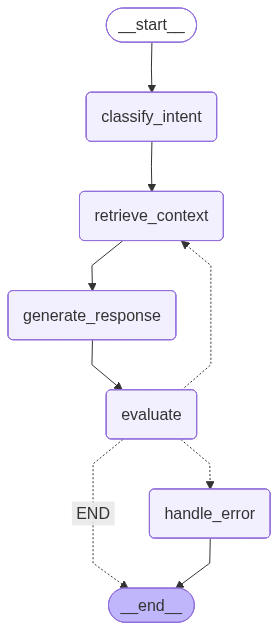

In [16]:
# 워크플로우 그래프 구성
builder = StateGraph(State)

# 노드 추가
builder.add_node('classify_intent', classify_intent)
builder.add_node('retrieve_context', retrieve_context)
builder.add_node('generate_response', generate_response)
builder.add_node('handle_error', handle_error)
builder.add_node('evaluate', evaluate)

# 엣지 연결
builder.add_edge(START,'classify_intent')
builder.add_edge('classify_intent', 'retrieve_context')
builder.add_edge('retrieve_context', 'generate_response')
builder.add_edge('generate_response', 'evaluate')
builder.add_conditional_edges(
    'evaluate',
    should_continue,
    {'END':END, 'handle_error':'handle_error', 'retrieve_context': 'retrieve_context'}
)

# 시작 노드 설정


# 그래프 컴파일
graph = builder.compile()

graph

기존의 플로우에 추가된 노드인   
 추가 검색을 판단하는 Evaluation 노드의 작동을 확인합니다.  


In [17]:
import pprint
test_questions = [
    "회사의 휴가 정책에 대해 알려주세요",
    "김지훈 직원의 스킬셋이 뭔가요?",
    "휴가신청서 양식을 보여주세요",
]

for question in test_questions:
    result = graph.invoke({'question': question, 'draft':'',
                           'retrieval_count':0})
    print('Question:', result['question'],"\nResult:", result['draft'])
    print('\n'+"-" * 50+'\n')

## Evaluation: explanation='The user is asking a question about company policy and the previous turn provided enough information about it, so no further retrieval is needed.' retrieval_needed=False target_db='policy' query='휴가 정책'
Question: 회사의 휴가 정책에 대해 알려주세요 
Result: 회사의 휴가 정책은 다음과 같습니다:

*   **연차휴가**:
    *   1년 근속 시 15일 부여
    *   3년 이상 근속 시 1년당 1일 추가 (최대 25일)
    *   분기별 최소 1회 이상 사용 권장
    *   미사용 연차 보상: 통상임금 기준 지급
*   **반차제도**:
    *   오전반차(09:00-13:00), 오후반차(13:00-18:00)
    *   2시간 단위 시간연차 사용 가능
*   **경조사 휴가**:
    *   본인 결혼: 5일
    *   자녀 결혼: 1일
    *   부모/배우자 사망: 5일
    *   조부모/형제자매 사망: 3일
*   **특별 휴가**:
    *   출산전후 휴가: 90일
    *   배우자 출산휴가: 10일
    *   난임치료휴가: 연간 3일
    *   자녀 돌봄 휴가: 연간 10일

--------------------------------------------------

## Evaluation: explanation='김지훈 직원의 스킬셋을 확인하기 위해 user DB에서 김지훈의 스킬셋을 검색했고, 검색 결과에서 스킬셋을 추출했습니다.' retrieval_needed=False target_db='user' query='김지훈 스킬셋'
Question: 김지훈 직원의 스킬셋이 뭔가요? 
Result: Python,Java,AWS,Kubernetes

-----------------

In [18]:
import pprint
test_questions = [
    "다음 달에 결혼하는데, 결혼 휴가는 며칠인가요?",
    "출장신청서 쓰는데, 지켜야 될 점 있나요?"
]

for question in test_questions:
    result = graph.invoke({'question': question, 'draft':'',
                           'retrieval_count':0})
    print('Question:', result['question'],"\nResult:", result['draft'])
    print('\n'+"-" * 50+'\n')

## Evaluation: explanation='결혼 휴가에 대한 답변이 완료되었으므로 추가 검색이 필요하지 않습니다.' retrieval_needed=False target_db='policy' query=''
Question: 다음 달에 결혼하는데, 결혼 휴가는 며칠인가요? 
Result: 본인 결혼 시 5일의 경조사 휴가가 부여됩니다.

--------------------------------------------------

## Evaluation: explanation='추가적인 DB 검색은 필요하지 않습니다.' retrieval_needed=False target_db='policy' query=''
Question: 출장신청서 쓰는데, 지켜야 될 점 있나요? 
Result: 출장신청서 작성 시 다음 사항을 참고하세요:

1.  해외출장은 최소 2주 전, 국내출장은 최소 3일 전에 신청해야 합니다.
2.  출장 후 5일 이내에 출장보고서를 제출해야 합니다.
3.  교통비, 숙박비 등 영수증 원본을 첨부해야 합니다.
4.  해외출장 시 여권/비자 사본을 첨부해야 합니다.
5.  필요에 따라 출장계획서, 항공권/숙박 예약증, 방문처 일정 확인서 등의 첨부서류를 준비해야 합니다.

--------------------------------------------------



In [19]:
import pprint
test_questions = [
    "스킬셋에 Kubernetes 가 있는 직원 모두 알려줘.",
]

for question in test_questions:
    result = graph.invoke({'question': question, 'draft':'',
                           'retrieval_count':0})
    print('Question:', result['question'],"\nResult:", result['draft'])
    print('\n'+"-" * 50+'\n')

## Evaluation: explanation='추가적인 DB 검색이 필요하지 않습니다.' retrieval_needed=False target_db='user' query=''
Question: 스킬셋에 Kubernetes 가 있는 직원 모두 알려줘. 
Result: 김지훈, 권태영, 박준호

--------------------------------------------------



In [20]:
# 여러 개의 RAG가 모두 활용되어야 하는 경우
# + 반복 실행이 필요한 경우

test_questions = [
    "야 나 김지훈인데, 25년 3월 22일부터 26일까지 여행 가게 휴가 신청서 작성해줘.",
]

for question in test_questions:
    result = graph.invoke({'question': question, 'draft':'',
                           'retrieval_count':0})
    print('Question:', result['question'],"\nResult:", result['draft'])
    print('\n'+"-" * 50+'\n')

## Evaluation: explanation='사용자 이름, 휴가 시작 날짜, 휴가 종료 날짜를 바탕으로 휴가 신청서 작성이 가능합니다. 추가적으로 사용자 정보를 DB에서 검색하여 신청서에 기입해야 합니다.' retrieval_needed=True target_db='user' query='김지훈'
## Evaluation: explanation='추가적으로 검색할 정보가 없습니다.' retrieval_needed=False target_db='policy' query=''
Question: 야 나 김지훈인데, 25년 3월 22일부터 26일까지 여행 가게 휴가 신청서 작성해줘. 
Result: 휴가신청서

문서번호: VAC-{YYYY}{MM}{DD}-{SEQ} 작성일자: {YYYY}-{MM}-{DD}

1. 신청자 정보

소속: 개발본부/백엔드팀

성명: 김지훈

사번: E001

직급: 수석연구원

2. 휴가 정보

2.1 휴가 유형

[ ] 연차휴가

[ ] 반차(오전)

[ ] 반차(오후)

[ ] 병가

[ ] 경조사휴가

[ ] 출산휴가

[ ] 기타

2.2 휴가 기간

시작일: 2025-03-22

종료일: 2025-03-26

사용일수: {일수}일

2.3 휴가 사유

{상세 사유 기재}

3. 업무 인수인계

3.1 인수자 정보

성명: {인수자성명}

직급: {인수자직급}

3.2 인수인계 사항

{주요 인수인계 내용}

4. 비상연락망

연락처: 010-1234-5678

위치: {휴가 중 위치}

5. 결재선

팀장: 이미영 (서명)

인사팀장: 양수빈 (서명)

대표이사: {대표이사명} (서명)

참고사항

연차휴가는 최소 3일 전 신청 필수

경조사 휴가는 관련 증빙서류 첨부 필수

병가는 3일 이상 시 진단서 첨부 필수

긴급휴가 시 팀장 유선 보고 후 당일 신청 가능

--------------------------------------------------



In [21]:
result

{'question': '야 나 김지훈인데, 25년 3월 22일부터 26일까지 여행 가게 휴가 신청서 작성해줘.',
 'target_db': 'policy',
 'query': '',
 'retrieval_needed': False,
 'context': ['사용자 정보:\nemployee_id: E001\nname: 김지훈\ndepartment: 개발본부\nteam: 백엔드팀\nposition: 수석연구원\njoin_date: 2018-03-01\nemail: jihoon.kim@company.com\nphone: 010-1234-5678\nskills: Python,Java,AWS,Kubernetes\ncertifications: AWS Solutions Architect,PMP\neducation: 서울대 컴퓨터공학 박사\nprojects: CloudMigration,PaymentSystem\nlanguages: Korean,English,Japanese\napproval_level: 3\nsystem_access: DevOps,AWS,Jira+\n\nemployee_id: E002\nname: 이미영\ndepartment: 마케팅본부\nteam: 브랜드팀\nposition: 팀장\njoin_date: 2019-01-15\nemail: miyoung.lee@company.com\nphone: 010-2345-6789\nskills: Marketing Strategy,Brand Management,Digital Marketing\ncertifications: Google Analytics,Facebook Blueprint\neducation: 연세대 경영학 석사\nprojects: BrandRenewal2023,GlobalMarketing\nlanguages: Korean,English\napproval_level: 4\nsystem_access: Adobe,Salesforce+\n\nemployee_id: E003\nname: 박성준\ndepartment